# Load libs

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm

# Prepare prompt

In [2]:
prompt = "face of an old lady"

# Load input and mask images

## Input image

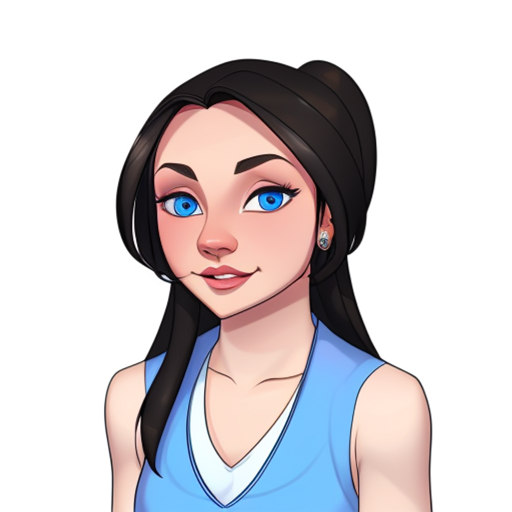

In [3]:
input_image = Image.open("input.png").convert("RGB").resize((512, 512))
input_image

In [4]:
# convert image to tensor
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
])
image = transform(input_image).to(torch.float32).to("mps")

### Mask image

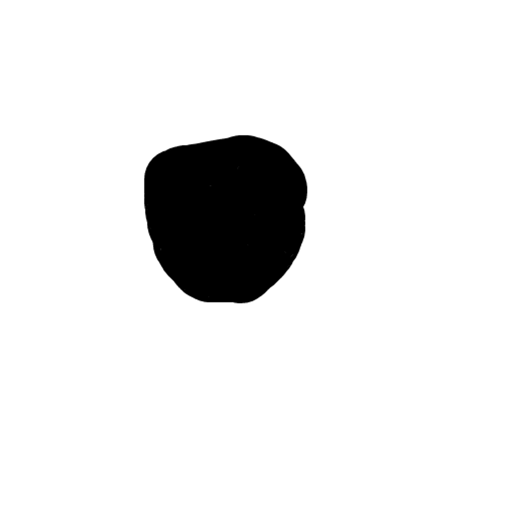

In [5]:
mask_image = Image.open("mask.png").resize((512, 512))
mask_image

In [ ]:
mask = transform(mask_image).to(torch.float32).to("mps")

### Mask image has transparency.
### We need to convert background (transparent layer) to black and mask area to white

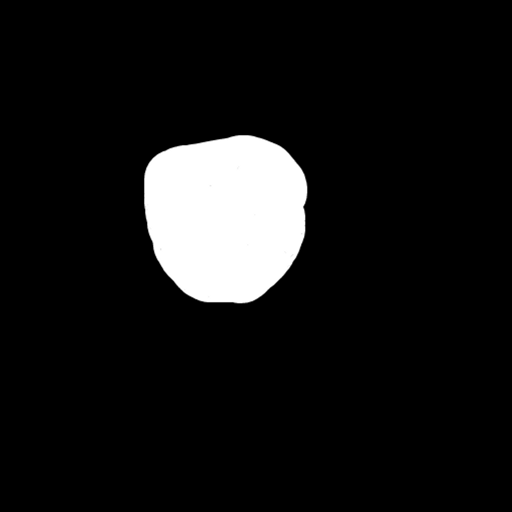

In [6]:
def invert(image):
    return image.point(lambda x: 255 - x)

new_image = Image.new("RGBA", mask_image.size, "WHITE")
new_image.paste(mask_image, (0, 0), mask_image)
mask_image = invert(new_image.convert("L"))
mask_image

### Now, since we want to achive diffusion strength feature we have to apply different masks to different strength values (floats).
### To achieve this, we can first find the contours of the original mask, subtract the contours from the original mask to make its size smaller. If we do this enough, we will hit a limit. Then, we can use this limit to scale for our diffusion strength between 0 and 1.

In [8]:
def get_mask_borders(image, width):
    """Get the contours/borders of a mask image."""
    if isinstance(image, Image.Image):
        image = np.array(image)

    bg = np.zeros(image.shape)
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest = 0
    bigcontour = None

    for contour in contours:
        area = cv2.contourArea(contour) 
        if area > biggest:
            biggest = area
            bigcontour = contour
            
    return cv2.drawContours(bg, contours=[bigcontour], contourIdx=0, color=(255, 255, 255), thickness=width)

In [9]:
def get_strength_limit(mask_image):
    """Get the strength limit of a mask image."""
    mask_image = mask_image.copy()
    strength_limit = 0
    while True:
        try:
            mask_borders_image = get_mask_borders(mask_image, 1)
            mask_image -= mask_borders_image
            mask_image = Image.fromarray(mask_image).convert("L")
            strength_limit += 1
        except:
            return strength_limit

In [10]:
strength_limit = get_strength_limit(mask_image)

In [11]:
# we need to scale the strength of the diffusion to the strength limit
def scale_diffusion_strength_to_limit(diffusion_strength, strength_limit):
    return int(diffusion_strength * strength_limit)

In [12]:
scale_diffusion_strength_to_limit(0.2)  # let's see what the strength limit is

16

In [17]:
def get_mask(mask_image, strength):
    """Get the mask image for a given strength."""
    mask_image = mask_image.copy()
    limit = scale_diffusion_strength_to_limit(strength)
    for _ in range(limit):
        im2 = get_mask_borders(mask_image, 1)
        mask_image -= im2
        mask_image = Image.fromarray(mask_image).convert("L")
    return mask_image

### Define stable diffusion inpainting pipeline
### We are using runwaylm/stable-diffusion-inpainting from huggingface
#### Since the implementation completed in a MacBook Pro M1, we are going to use "mps" as our device

In [14]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float32,
)
pipe.enable_attention_slicing()
pipe.to("mps")

/Users/kaplan/opt/anaconda3/envs/inpainting/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.15.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Let's generate an image to make sure everything works in order

  0%|          | 0/50 [00:00<?, ?it/s]

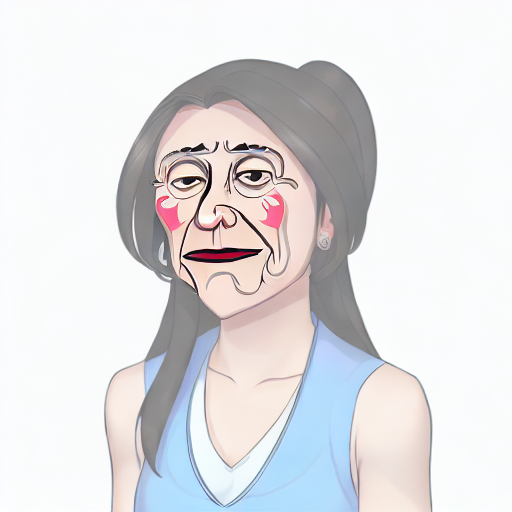

In [15]:
pipe(prompt=prompt, image=image, mask_image=mask).images[0]

## In order to obtain a feature that would control the scale of originality, we are going to use a "diffusion strength" variable.
### But, first, let's see the masks with different values of diffusion strength parameter.

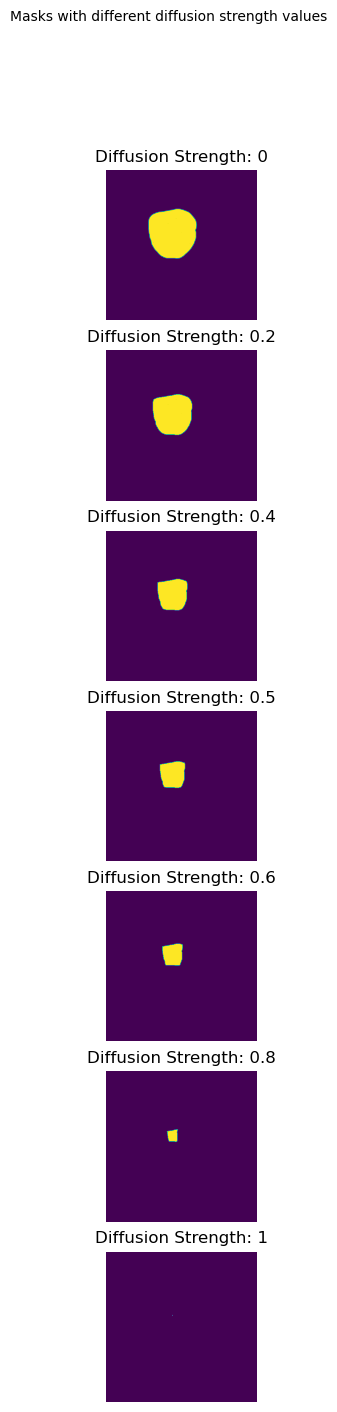

In [34]:
strengths = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1]

fig, axes = plt.subplots(7, 1, figsize=(10, 16))
fig.suptitle(f"Masks with different diffusion strength values", fontsize=10)

for str_idx, strength in enumerate(strengths):
    axes[str_idx].imshow(get_mask(mask_image, strength))
    axes[str_idx].axis("off")
    axes[str_idx].set_title(f"Diffusion Strength: {strength}")

# Let's generate images with the different masks (created with different diffusion strength values)

In [22]:
images = [input_image]
for strength in tqdm(strengths):
    # get the mask for the current strength
    mask_ = get_mask(mask_image, strength)
    mask_ = transform(mask_).to(torch.float32).to("mps")

    # run the inpainting pipeline
    output = pipe(prompt=prompt, image=image, mask_image=mask_).images[0]
    images.append(output)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Plot the results

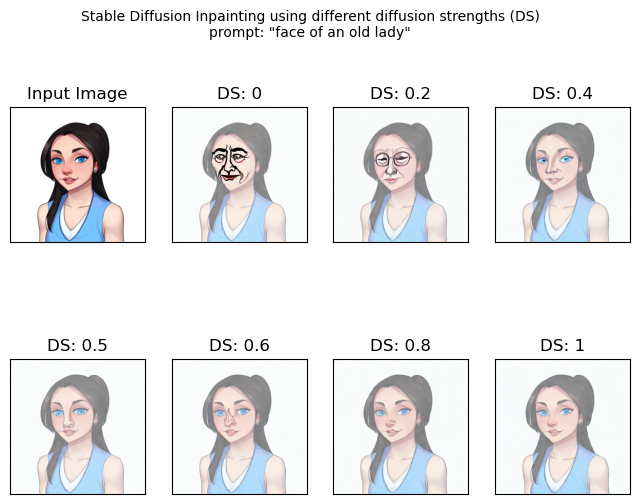

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(8, 6))
fig.suptitle(f"Stable Diffusion Inpainting using different diffusion strengths (DS)\nprompt: \"{prompt}\"", fontsize=10)

for i in range(2):
    for j in range(4):
        axes[i, j].imshow(images[i * 4 + j])
        if i == 0 and j == 0:
            axes[i, j].set_title(f"Input Image")
        else:
            axes[i, j].set_title(f"DS: {strengths[i * 4 + j - 1]}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# As we can see, the current approach works fine. For diffusion strength close to 1, the generated images resemble the original, while if we get closer to 0, we start to get different faces from the original.